# Analyzing Monte Carlo Simulations

## Single Run Analysis

       net1          iout     idump      i_in         ilout    ildump  bit  \
0  0.347674  5.403275e-08  0.000003  0.000005 -4.813927e-13  0.000005    0   
1  0.347681  7.987112e-08  0.000003  0.000005  3.467667e-08  0.000005    1   
2  0.347715  1.052176e-07  0.000003  0.000005  6.779408e-08  0.000005    2   
3  0.347723  1.346614e-07  0.000003  0.000005  1.057145e-07  0.000005    3   
4  0.347864  1.567453e-07  0.000003  0.000005  1.339468e-07  0.000005    4   

           diff  
0           NaN  
1  2.583837e-08  
2  2.534650e-08  
3  2.944382e-08  
4  2.208387e-08  
real 1bit current:         7.98711202e-08
theoretical 1bit current:  7.8125e-09


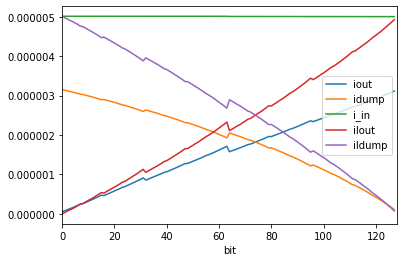

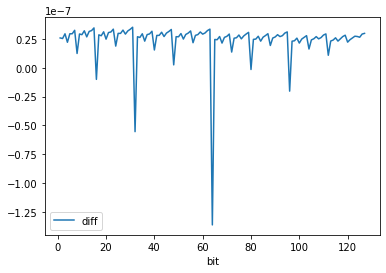

In [22]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# load data
data = pd.read_csv("data/mc_dac1.txt", sep=" +", engine='python')
data.columns = ["net1", "iout", "idump", "i_in", "ilout", "ildump"]
data["bit"] = data.index

#generate current steps
data["diff"] = data["iout"].diff(1)

# print sample of dataframe
print(data.head())

# print expected 1bit transistion
print("real 1bit current:        ", data.iout[1])
print("theoretical 1bit current: ", 1e-6/128)


data.plot("bit", ["iout", "idump", "i_in", "ilout", "ildump"], xlim=(0,128))

data.plot("bit", "diff")

## Multi-Run Analysis

       net1          iout     idump      i_in         ilout    ildump  bit  \
0  0.347674  5.403275e-08  0.000003  0.000005 -4.813927e-13  0.000005    0   

   diff  
0   0.0  


/home/madvlsi/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


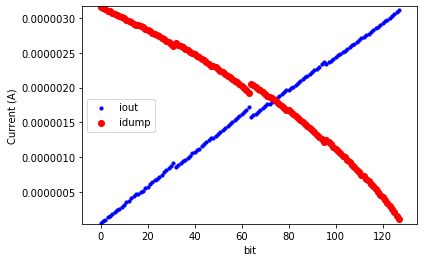

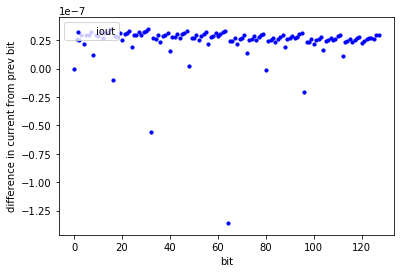

7.98711202e-08


In [23]:
runs = 1
#init data with first run
data = pd.read_csv("data/mc_dac1.txt", sep=" +", engine='python')

#combine multiple runs
for i in range(1, runs):
    data = pd.concat([data, pd.read_csv("data/mc_dac" + str(i + 1)+".txt", sep=" +", engine='python')])
data.columns = ["net1", "iout", "idump", "i_in", "ilout", "ildump"]
data["bit"] = data.index % 128
data["diff"] = data["iout"].diff(1)

#remove diffs at bits = 0
data["diff"].loc[data["bit"] == 0] = 0
print(data.loc[data["bit"] == 0])

fig = plt.figure()
ax1 = fig.add_subplot()

ax1.scatter(data.bit, data.iout, s=10, c='b', label='iout')
ax1.scatter(data.bit, data.idump, c='r', label='idump')
# ax1.scatter(data.bit, data.i_in, c='g', label='i in')
plt.ylim(data.iout.min()-1e-8, data.idump.max()+1e-8)
# plt.xlim(60,80)
plt.legend(loc='center left');
plt.xlabel("bit")
plt.ylabel("Current (A)")
plt.show()

#plotting diffs
fig = plt.figure()
ax1 = fig.add_subplot()
ax1.scatter(data["bit"], data["diff"], s=10, c='b', label='iout')
plt.ylim(data["diff"].min()-1e-8, data["diff"].max()+1e-8)
# plt.xlim(60,80)
plt.legend(loc='upper left');
plt.xlabel("bit")
plt.ylabel("difference in current from prev bit")
plt.show()

#density plot of diff
# data["diff"].plot.density()

print(data["iout"].iloc[1])

### DNL and INL distributions

7.98711202e-08


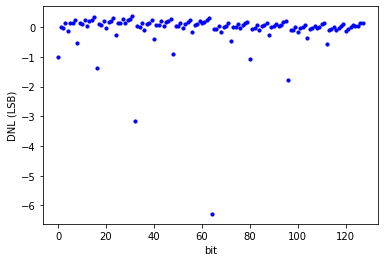

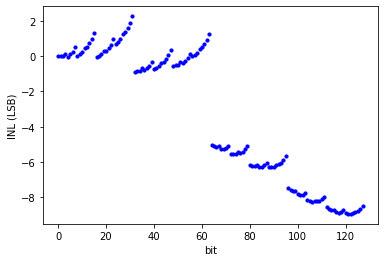

In [24]:
#generate DNL & INL Columns
dnl = []
inl = []
print(data["iout"].iloc[1])
for i in range(128*runs):    
    if i % 128 == 0:
        lsb_current = data["iout"].iloc[i+1] - data["iout"].iloc[i]
        dnl.append(data["diff"].iloc[i] / lsb_current - 1)
        inl.append(0)
    else:
        dnl.append(data["diff"].iloc[i] / lsb_current - 1)
        inl.append(dnl[-1] + inl[-1])
        

        
data["dnl"] = dnl
data["inl"] = inl

# print(dnl)
#DNL
fig = plt.figure()
ax1 = fig.add_subplot()

ax1.scatter(data.bit, data.dnl, s=10, c='b', label="dnl")
plt.xlabel("bit")
plt.ylabel("DNL (LSB)")
plt.show()

#INL
fig = plt.figure()
ax1 = fig.add_subplot()

ax1.scatter(data.bit, data.inl, s=10, c='b', label="inl")
plt.xlabel("bit")
plt.ylabel("INL (LSB)")
plt.show()

# Iout Current Mirror Characteristics

## Sweeping I_in with an ideal current source from 0 to 1ua

<img src="./img/iout_mirror.png" width="400">

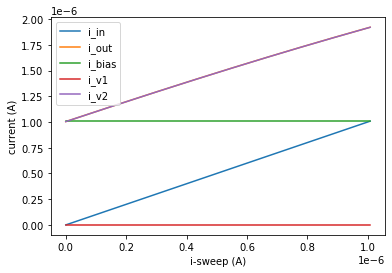

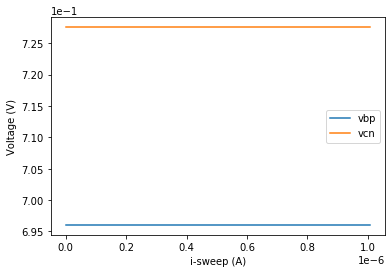

In [4]:


import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# load data
data = pd.read_csv("data/iout_mirror1.txt", sep=" +", engine='python')
data.columns = ["isweep", "i_in", "i_out", "i_bias","i_v1", "i_v2", "vbp", "vcn"]

data.plot("isweep", ["i_in", "i_out", "i_bias","i_v1", "i_v2"])
plt.xlabel("i-sweep (A)")
plt.ylabel("current (A)")
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.show()

data.plot("isweep", ["vbp", "vcn"])
plt.xlabel("i-sweep (A)")
plt.ylabel("Voltage (V)")
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.show()

## Sweeping I_in with dioded connected PMOS

<img src="./img/iout_mirror_diode.png" width="400">

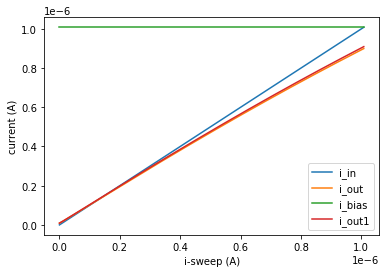

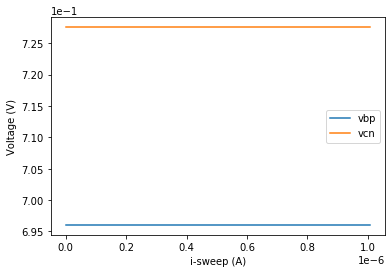

In [15]:
# load data
data = pd.read_csv("data/iout_mirror3.txt", sep=" +", engine='python')
data.columns = ["isweep", "i_in", "i_out", "i_bias","i_v1", "i_v2", "i_out1", "vbp", "vcn"]

data.plot("isweep", ["i_in", "i_out", "i_bias", "i_out1"])
plt.xlabel("i-sweep (A)")
plt.ylabel("current (A)")
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.show()

data.plot("isweep", ["vbp", "vcn"])
plt.xlabel("i-sweep (A)")
plt.ylabel("Voltage (V)")
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.show()

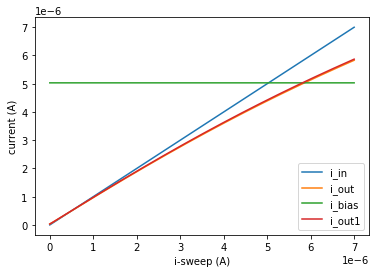

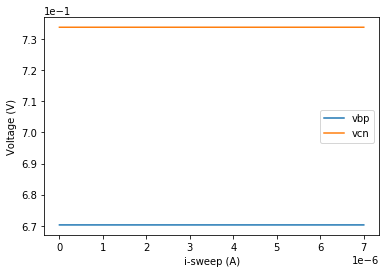

In [14]:
# load data
data = pd.read_csv("data/iout_mirror4.txt", sep=" +", engine='python')
data.columns = ["isweep", "i_in", "i_out", "i_bias","i_v1", "i_v2", "i_out1", "vbp", "vcn"]

data.plot("isweep", ["i_in", "i_out", "i_bias", "i_out1"])
plt.xlabel("i-sweep (A)")
plt.ylabel("current (A)")
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.show()

data.plot("isweep", ["vbp", "vcn"])
plt.xlabel("i-sweep (A)")
plt.ylabel("Voltage (V)")
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.show()